## Imports

In [1]:
%pip install einops
from einops import reduce, rearrange, repeat
from dataclasses import dataclass
import tensorflow as tf
import torch as t
import torch.nn as nn
from torch import einsum
import numpy as np
import math
import random
import tqdm.auto as tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

device = "cpu"
if t.cuda.is_available():
    device = "cuda"
print("Running on ", device)
import os
import csv
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00
Running on  cuda


# ASL Dataset

In [2]:
# prompt: mount my drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Utility Functions
The visualization/utility functions were written using GPT4

In [3]:
def show_patches(patches, width):
    num_patches = len(patches)
    grid_cols = width
    grid_rows = int(math.ceil(num_patches / grid_cols))

    fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(10, 10), squeeze=True)

    for i in range(grid_rows):
        for j in range(grid_cols):
            index = i * grid_cols + j
            ax = axes[i, j] if grid_rows > 1 else axes[j]
            if index < num_patches:
                ax.imshow(patches[index])
                ax.axis('off')
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def display_patches(patches, patch_size=4, grid_size=7, separation=0):
    # Total size of the image including separations
    total_size = grid_size * patch_size + (grid_size - 1) * separation

    # Create an empty array for the full image with separations
    full_image = np.zeros((total_size, total_size))

    # Arrange the patches into the full image
    for i in range(grid_size):
        for j in range(grid_size):
            start_x = i * (patch_size + separation)
            start_y = j * (patch_size + separation)
            patch = np.array(patches[i * grid_size + j]).reshape(patch_size, patch_size)
            full_image[start_x:start_x + patch_size, start_y:start_y + patch_size] = patch

    # Display the image
    plt.imshow(full_image, cmap='gray')
    plt.axis('off')
    plt.show()


In [5]:
def display_patch_grid(patches, grid_size=7, patch_size=4, separation=1):
    """
    Display patches in a grid with slight separation.

    :param patches: List of 1D arrays representing the patches.
    :param grid_size: The number of patches along one dimension of the grid.
    :param patch_size: The size of one side of a square patch.
    :param separation: The number of pixels separating the patches.
    """
    # Total size of the grid including separations
    total_size = grid_size * patch_size + (grid_size - 1) * separation

    # Create an empty array for the full grid
    full_grid = np.zeros((total_size, total_size))

    # Arrange the patches into the full grid
    for i in range(grid_size):
        for j in range(grid_size):
            start_x = i * (patch_size + separation)
            start_y = j * (patch_size + separation)
            # Reshape each patch to 2D before placing it in the grid
            patch_2d = patches[i * grid_size + j].reshape(patch_size, patch_size)
            full_grid[start_x:start_x + patch_size, start_y:start_y + patch_size] = patch_2d

    # Display the grid
    plt.imshow(full_grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [59]:
def display_image(pixels, image_size=28, cmap='gray'):
    image = np.array(pixels).reshape(image_size, image_size)

    # Display the image
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

# Vision Transformer Implementation
Based on the TrOCR paper.

## Configuration

In [28]:
@dataclass
class TFConfig:
    debug: bool = False

    # The Height and Width of a patch
    P: int = 4

    # The Dimension of the Model (size of a flattened patch)
    d_model: int = P * P

    # The number of transformer layers
    n_layers: int = 4

    # Base value to prevent division by zero
    ln_eps: float = 1e-5

    # The weight initialization range [-init_range, init_range]
    init_range: float = 0.02

    # The number of attention heads in each layer
    n_heads: int = 12

    # The hidden dimension of Q, K, V matrices
    d_head: int = 64

    # MLP hidden dimension
    d_mlp: int = 248

    # The number of classes, or the output size of the unembedder
    n_classes: int = 27


## Unembedder (Classifier)

In [29]:
# Takes an input
# Resizes it to H x W
# Creates N = HW/P**2, PxP patches
# Turns these to greyscale
class TrOCRUnembedder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.d_model, cfg.n_classes)

    def forward(self, x):
        return self.fc1(x)

## Layer Normalization

In [30]:
class LayerNorm(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(self, residual):
        # calculate the standard deviation of each row
        residual = residual - reduce(residual, "b p d -> b p 1", "mean") # The 1 preserves the dimension?

        # divide by the square of each row + a small value, then find the square root
        scale = (reduce(residual.pow(2), "b p d -> b p 1", "mean") + self.cfg.ln_eps).sqrt()
        normalized = residual / scale

        # Because the algorithm said to, not really sure why
        #normalized = normalized * self.w + self.b

        return normalized

## MLP

In [31]:
# Classic MLP Layer
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.fc1 = nn.Linear(cfg.d_model, cfg.d_mlp)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(cfg.d_mlp, cfg.d_model)

        nn.init.normal_(self.fc1.weight, std=self.cfg.init_range)
        nn.init.normal_(self.fc2.weight, std=self.cfg.init_range)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Decoder and Encoder Attention

In [32]:
class EncoderAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        # Attention Weights
        self.Qs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Ks = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Vs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.Qbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Kbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Ob = nn.Parameter(t.zeros(cfg.d_model))

        # Initialize the Weights
        nn.init.normal_(self.Qs, std=self.cfg.init_range)
        nn.init.normal_(self.Ks, std=self.cfg.init_range)
        nn.init.normal_(self.Vs, std=self.cfg.init_range)
        nn.init.normal_(self.O, std=self.cfg.init_range)



    def forward(self, normalized_resid_pre):
        # Calculate query, key and value vectors
        q = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Qs) + self.Qbs
        k = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Ks) + self.Kbs
        v = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Vs) + self.Vbs

        # Calculate attention scores, then scale, and apply softmax
        attn_scores = einsum("b Q h k, b K h k -> b h Q K", q, k)
        attn_scores = attn_scores / np.sqrt(self.cfg.d_head)
        attn_pattern = attn_scores.softmax(-1)

        z = einsum("b K h k, b h Q K -> b Q h k", v, attn_pattern)

        # Apply another transformation to convert back to the right dimensions
        attn_out = einsum("b Q h k, h k d -> b Q d", z, self.O) + self.Ob

        return attn_out

In [33]:
class DecoderAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        # Attention Weights
        self.Qs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Ks = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Vs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.Qbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Kbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Ob = nn.Parameter(t.zeros(cfg.d_model))

        # Initialize the Weights
        nn.init.normal_(self.Qs, std=self.cfg.init_range)
        nn.init.normal_(self.Ks, std=self.cfg.init_range)
        nn.init.normal_(self.Vs, std=self.cfg.init_range)
        nn.init.normal_(self.O, std=self.cfg.init_range)

        # Register
        self.register_buffer("IGNORE", t.tensor(-1e5, dtype=t.float32, device=device))

        # Cache for the attention grid
        self.attn_cache = None


    def forward(self, normalized_resid_pre, encoder_output):
        assert(normalized_resid_pre.shape == encoder_output.shape)

        # Calculate query, key matrices from the encoder output
        q = einsum("b p d, h d k -> b p h k", encoder_output, self.Qs) + self.Qbs
        k = einsum("b p d, h d k -> b p h k", encoder_output, self.Ks) + self.Kbs

        # Calculate the value matrices from the normalized residual stream
        v = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Vs) + self.Vbs

        # Form the visually appealing attention grid
        attn_scores = einsum("b Q h k, b K h k -> b h Q K", q, k)
        attn_scores_masked = self.apply_causal_mask(attn_scores / np.sqrt(self.cfg.d_head))
        attn_pattern = attn_scores_masked.softmax(-1)

        z = einsum("b K h k, b h Q K -> b Q h k", v, attn_pattern)

        attn_out = einsum("b Q h k, h k d -> b Q d", z, self.O) + self.Ob

        return attn_out, attn_pattern

    def apply_causal_mask(self, attn_scores: t.Tensor):
        mask = t.triu(t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()

        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


class DecoderOnlyAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.cfg = cfg

        # Attention Weights
        self.Qs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Ks = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.Vs = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.Qbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Kbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Vbs = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.Ob = nn.Parameter(t.zeros(cfg.d_model))

        # Initialize the Weights
        nn.init.normal_(self.Qs, std=self.cfg.init_range)
        nn.init.normal_(self.Ks, std=self.cfg.init_range)
        nn.init.normal_(self.Vs, std=self.cfg.init_range)
        nn.init.normal_(self.O, std=self.cfg.init_range)

        # This is for cuda management
        self.register_buffer("IGNORE", t.tensor(-1e5, dtype=t.float32, device=device))

        # Cache for the attention grid
        self.attn_cache = None


    def forward(self, normalized_resid_pre, isHooked=False):
        # Calculate query, key matrices from the encoder output
        q = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Qs) + self.Qbs
        k = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Ks) + self.Kbs

        # Calculate the value matrices from the normalized residual stream
        v = einsum("b p d, h d k -> b p h k", normalized_resid_pre, self.Vs) + self.Vbs

        # Form the visually appealing attention grid
        attn_scores = einsum("b Q h k, b K h k -> b h Q K", q, k)
        attn_scores_masked = self.apply_causal_mask(attn_scores / np.sqrt(self.cfg.d_head))
        attn_scores = attn_scores_masked.softmax(-1)

        self.attn_cache = attn_scores

        z = einsum("b K h k, b h Q K -> b Q h k", v, self.attn_cache)

        attn_out = einsum("b Q h k, h k d -> b Q d", z, self.O) + self.Ob

        return attn_out

    def apply_causal_mask(self, attn_scores: t.Tensor):
        mask = t.triu(t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device), diagonal=1).bool()

        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores


    def get_attn_cache(self):
        return self.attn_cache


## Encoder Block

In [34]:
class EncoderBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        self.ln1 = LayerNorm(cfg)
        self.attn = EncoderAttention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(self, resid_pre):
        normalized_resid_pre = self.ln1(resid_pre)

        resid_mid = self.attn(normalized_resid_pre) + resid_pre

        normalized_resid_mid = self.ln2(resid_mid)

        resid_post = self.mlp(normalized_resid_mid) + resid_mid

        return resid_post

## Decoder Block

In [35]:
class DecoderBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # Create the objects needed for a decoder block
        self.ln = LayerNorm(cfg)
        self.attn = DecoderAttention(cfg)
        self.mlp = MLP(cfg)

    def forward(self, resid_pre, encoder_output):
        # Normalize the residual stream
        normalized_resid_pre = self.ln(resid_pre)

        # Apply Attention and add back onto the unnormalized stream
        # Notably this requires the encoder_output
        # You can pass in the residual stream twice to get a decoder only block, but why
        resid_mid = self.attn(normalized_resid_pre, encoder_output) + resid_pre

        # Normalize again
        normalized_resid_mid = self.ln(resid_mid)

        # Pass through the MLP layer, add back onto the residual stream
        resid_post = self.mlp(normalized_resid_mid) + resid_mid

        # Normalize one more time
        return self.ln(residual_post)


class DecoderOnlyBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # Objects needed by a decoder block
        self.ln1 = LayerNorm(cfg)
        self.attn = DecoderOnlyAttention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

        # Stores attention from the last inference
        self.attn_cache = None


    def forward(self, resid_pre):
        normalized_resid_pre = self.ln1(resid_pre)
        resid_mid = self.attn(normalized_resid_pre)

        # get the attn matrix
        self.attn_cache = self.attn.get_attn_cache()
        resid_mid = resid_mid + resid_pre
        normalized_resid_mid = self.ln2(resid_mid)

        resid_post = self.mlp(normalized_resid_mid) + resid_mid

        return resid_post


    def get_attn_cache(self):
        return self.attn_cache

## Vision Transformer

In [36]:
# Takes an input
# Resizes it to H x W
# Creates N = HW/P**2, PxP patches
# Turns these to greyscale
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.positional_embeddings = nn.Parameter(t.randn(49, 16), requires_grad=False)

    def forward(self, im, vis=False):
        # Create the patches from the image
        im_reshaped = im.view(28, 28)
        patches = []
        for i in range(0, 28, 4):
            for j in range(0, 28, 4):
                patch = im_reshaped[i:i+4, j:j+4]
                patches.append(t.Tensor(patch))

        # Optionally show an image of the patches in place
        if vis:
            display_patch_grid(patches)


        patches = t.stack(patches)

        # Add the positional embeddings
        for patch in patches:
            patches[i] += self.positional_embeddings[i].view(4, 4)

        # Flatten the patches
        patches = patches.view(49, -1)

        # Normalize and return these patches
        return nn.functional.softmax(patches, dim=-1)

In [43]:
class Unembedder(nn.Module):
    def __init__(self, n_classes, init_range):
        super().__init__()
        # Define the parameters and initialize
        self.W = nn.Parameter(t.empty(49 * 16, n_classes))
        self.b = nn.Parameter(t.zeros(n_classes))

        nn.init.normal_(self.W, std=init_range)

    def forward(self, logits):
        # Flatten the input tensor, why is it shaped so weird
        logits = logits.view(logits.shape[0], -1)

        # Compute the matrix product using einsum and add the bias
        pred = t.einsum('bi,ij->bj', logits, self.W) + self.b
        return pred

In [41]:
# This is another version so I can extract the attention matrices
class TrASLa(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        # Create the necessary objects
        self.unembedder = Unembedder(cfg.n_classes, cfg.init_range)
        self.decoder_blocks = nn.ModuleList([DecoderOnlyBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)

    def forward(self, residual_stream):
        # Pass the residual stream through all of the blocks
        for block in self.decoder_blocks:
            residual_stream = block(residual_stream)

        # Normalize and add back to the stream
        residual_stream = self.ln_final(residual_stream) + residual_stream

        # Unembed and return logits
        logits = self.unembedder(residual_stream)
        return logits

    # Utility function for getting the attention
    def getAttnPatterns(self):
        attn_patterns = []
        for block in self.decoder_blocks:
            attn_patterns.append(block.get_attn_cache())
        return attn_patterns

# ASL Alpabet Dataset Large

In [18]:
import csv
import os


def filename_to_class(filename):
    if filename == 'Blank.csv':
        return 26
    else:
        return ord(filename.replace('.csv', '')) - ord('A')


large_training_data = []
directory = '/content/drive/MyDrive/ASL_Dataset/archive-3/Train_csv_resized_l'

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        class_label = filename_to_class(filename)
        with open(os.path.join(directory, filename), newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if class_label == 9 or class_label == 25:
                    continue
                image = [float(pixel) for pixel in row[1:]]
                large_training_data.append((image, class_label))


In [19]:

large_testing_data = []
directory = '/content/drive/MyDrive/ASL_Dataset/archive-3/Test_csv_resized_l'

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        class_label = filename_to_class(filename)
        with open(os.path.join(directory, filename), newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                if class_label == 9 or class_label == 25:
                    continue
                image = [float(pixel) for pixel in row[1:]]
                large_testing_data.append((image, class_label))

In [ ]:
print(len(large_training_data))
print(len(large_testing_data))

21798
2500


# ASL Alphabet Dataset

In [20]:
!git clone https://github.com/crsnkntn/ASL-Dataset.git

Cloning into 'ASL-Dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 30.12 MiB | 20.52 MiB/s, done.


In [21]:
with open('/content/ASL-Dataset/sign_mnist_train.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for row in reader:
        label = int(row[0])
        image = [float(pixel) for pixel in row[1:]]
        large_training_data.append((image, label))

testing_data = []
with open('/content/ASL-Dataset/sign_mnist_test.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for row in reader:
        label = int(row[0])
        image = [float(pixel) for pixel in row[1:]]
        large_testing_data.append((image, label))

In [52]:
sorted_data = [[] for _ in range(27)]

for im, lbl in large_training_data:
    sorted_data[lbl].append((im, lbl))

for im, lbl in large_testing_data:
    sorted_data[lbl].append((im, lbl))

In [ ]:
for cls in sorted_data:
    print(len(cls))

In [ ]:
clsA = [0, 4, 13, 14, 18, 19]
clsB = [3, 5, 8, 10, 11, 17, 20, 21, 22]
clsC = [1, 2, 6, 7, 12, 15, 16, 23, 24, 27]

In [ ]:
clsA_training_data = []
clsA_testing_data = []

clsB_training_data = []
clsB_testing_data = []

clsC_training_data = []
clsC_testing_data = []

for i, cls_data in enumerate(sorted_data):
    if i in clsA:
        clsA_training_data += cls_data[:int(len(cls_data) * 0.8)]
        clsA_testing_data += cls_data[int(len(cls_data) * 0.8):]
    elif i in clsB:
        clsB_training_data += cls_data[:int(len(cls_data) * 0.8)]
        clsB_testing_data += cls_data[int(len(cls_data) * 0.8):]
    elif i in clsC:
        clsC_training_data += cls_data[:int(len(cls_data) * 0.8)]
        clsC_testing_data += cls_data[int(len(cls_data) * 0.8):]

In [ ]:
training_data = []
testing_data = []

for cls_data in sorted_data:
    training_data += cls_data[:int(len(cls_data) * 0.8)]
    testing_data += cls_data[int(len(cls_data) * 0.8):]

In [ ]:
random.shuffle(large_training_data)
random.shuffle(large_testing_data)

In [ ]:
print("N training examples: ", len(training_data))
print("N testing examples: ",len(testing_data))

N training examples:  27693
N testing examples:  6934


In [22]:
batch_size = 8

training_batches = []
for i in range(0, len(large_training_data), batch_size):
    batch = large_training_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image).to(device) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long).to(device)
    lb_one_hot = nn.functional.one_hot(lb_tensor.to(device), num_classes=27).to(t.float32)[:, None, :]
    training_batches.append((im, lb_one_hot))


testing_batches = []
for i in range(0, len(large_testing_data), batch_size):
    batch = large_testing_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image).to(device) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long).to(device)
    lb_one_hot = nn.functional.one_hot(lb_tensor, num_classes=27).to(t.float32)[:, None, :]
    testing_batches.append((im, lb_one_hot.to(device)))


import random
random.shuffle(training_batches)

In [ ]:
clsA_training_batches = []
for i in range(0, len(clsA_training_data), batch_size):
    batch = clsA_training_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor.to(device), num_classes=27).to(t.float32)[:, None, :]
    clsA_training_batches.append((im, lb_one_hot))


clsA_testing_batches = []
for i in range(0, len(clsA_testing_data), batch_size):
    batch = clsA_testing_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor, num_classes=27).to(t.float32)[:, None, :]
    clsA_testing_batches.append((im, lb_one_hot.to(device)))


clsB_training_batches = []
for i in range(0, len(clsB_training_data), batch_size):
    batch = clsB_training_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor.to(device), num_classes=27).to(t.float32)[:, None, :]
    clsB_training_batches.append((im, lb_one_hot))


clsB_testing_batches = []
for i in range(0, len(clsB_testing_data), batch_size):
    batch = clsB_testing_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor, num_classes=27).to(t.float32)[:, None, :]
    clsB_testing_batches.append((im, lb_one_hot.to(device)))


clsC_training_batches = []
for i in range(0, len(clsC_training_data), batch_size):
    batch = clsC_training_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor.to(device), num_classes=27).to(t.float32)[:, None, :]
    clsC_training_batches.append((im, lb_one_hot))


clsC_testing_batches = []
for i in range(0, len(clsC_testing_data), batch_size):
    batch = clsC_testing_data[i:i+batch_size]
    im, lb = zip(*batch)
    im = t.stack([t.tensor(image) for image in im]).to(device)
    lb_tensor = t.tensor(lb, dtype=t.long)
    lb_one_hot = nn.functional.one_hot(lb_tensor, num_classes=27).to(t.float32)[:, None, :]
    clsC_testing_batches.append((im, lb_one_hot.to(device)))

In [ ]:
random.shuffle(clsA_training_batches)
random.shuffle(clsA_testing_batches)
random.shuffle(clsB_training_batches)
random.shuffle(clsB_testing_batches)
random.shuffle(clsC_training_batches)
random.shuffle(clsC_testing_batches)

In [ ]:
sorted_batches = t.Tensor(26).to(device)

# Training

In [23]:
def train_this(model, emb, data, n_epochs=3, lr=2e-5):
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    optimizer = t.optim.Adam(model.parameters(), lr)
    model.train()
    # Training loop
    for epoch in range(n_epochs):
        random.shuffle(data)
        train_flag = 0
        for x_batch, y_batch in data:
            # Process x_batch
            e = t.stack([emb(x) for x in x_batch]).to(device)

            # Process y_batch
            y_pred = model(e)
            loss = criterion(y_pred, y_batch.squeeze())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}")

In [ ]:
def finetune1_this(model, emb, data, n_epochs=3, lr=2e-5):
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    optimizer = t.optim.Adam(model.parameters(), lr)
    model.train()
    # Training loop
    for epoch in range(n_epochs):
        random.shuffle(data)
        train_flag = 0
        for x_batch, y_batch in data:
            # Process x_batch
            e = t.stack([emb(x) for x in x_batch]).to(device)

            # Process y_batch
            y_pred = model(e)

            loss = criterion(y_pred, y_batch.squeeze())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item()}")

In [25]:
def validate_this(model, emb, data):
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    model.eval()
    loss_count = 0
    n = 0
    # Training loop
    with t.no_grad():
        for x_batch, y_batch in data:
            # Process x_batch
            e = t.stack([emb(x) for x in x_batch]).to(device)

            # Process y_batch
            y_pred = model(e)

            loss = criterion(y_pred, y_batch.squeeze())
            loss_count += loss.item()
            n += 1

    return loss_count / n

In [24]:
def test_this1(model, emb, data):
    model.eval()
    n_correct = 0
    with t.no_grad():
        # Training loop
        for x_i, y_i in data:
            # Properly format y_i
            lb_tensor = t.tensor(y_i, dtype=t.long)
            y_i = nn.functional.one_hot(lb_tensor.to(device), num_classes=26).to(t.float32)

            # Forward pass
            e = emb(x_i).to(device)
            y = model(e)

            loss = criterion(y, y_i)
            n_correct += (t.argmax(y) == t.argmax(y_i))
    print(f"Performance: {n_correct/len(data)}")

def test_this(model, emb, data):
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    model.eval()
    perf = t.Tensor(t.zeros(27, 27))
    loss_count = 0
    n = 0
    # Training loop
    with t.no_grad():
        for x_batch, y_batch in data:
            # Process x_batch
            e = t.stack([emb(x) for x in x_batch]).to(device)

            # Process y_batch
            y_pred = model(e)

            loss = criterion(y_pred, y_batch.squeeze())
            loss += loss.item()
            n += 1

            predicted_classes = t.argmax(y_pred, dim=1)
            actual_classes = t.argmax(y_batch.squeeze(), dim=1)

            for i in range(len(predicted_classes)):
                perf[actual_classes[i]][predicted_classes[i]] += 1
    return perf

In [ ]:
n_heads_list = [4, 6, 8, 12]
n_layers_list = [2, 4, 6]
init_range_list = [0.02, 0.08, 0.2]

for h in n_heads_list:
    for l in n_layers_list:
        for i in init_range_list:
            tf = TrASLa(TFConfig(n_layers=l, n_heads=h, init_range=i, d_mlp=420, n_classes=27)).to(device)
            embed = Embedder().to(device)
            train_this(tf, embed, training_batches[1000:], n_epochs=3, lr=1e-3)
            p = validate_this(tf, embed, training_batches[:1000])
            print(f"Model with n_heads={h}, n_layers={l}, init={i} performs: {p}")

In [84]:
tf = TrASLa(TFConfig(n_layers=4, n_heads=2, init_range=0.002, d_mlp=420, n_classes=27)).to(device)
embed = Embedder().to(device)
train_this(tf, embed, training_batches[1000:], n_epochs=2, lr=1e-3)
train_this(tf, embed, training_batches[1000:], n_epochs=2, lr=1e-4)
train_this(tf, embed, training_batches[1000:], n_epochs=1, lr=1e-5)
p = test_this(tf, embed, training_batches[:1000])
print(t.sum(t.diag(p)) / t.sum(p))

Epoch [1/2], Loss: 0.028621241450309753
Epoch [2/2], Loss: 0.012906072661280632
Epoch [1/2], Loss: 0.004508282523602247
Epoch [2/2], Loss: 0.004931635223329067
Epoch [1/1], Loss: 0.07942157238721848
tensor(0.7445)


In [50]:
t.save(tf.state_dict(), 'model_final_7442.pt')

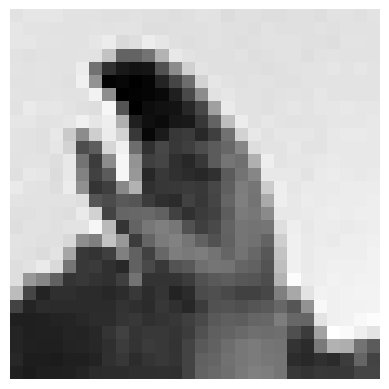

In [60]:
im = sorted_data[2][7][0]

display_image(im)

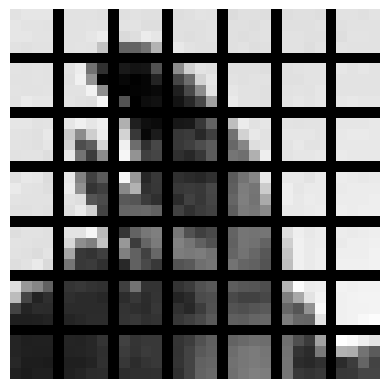

In [61]:
im_reshaped = t.Tensor(im).view(28, 28)
patches = []
for i in range(0, 28, 4):
    for j in range(0, 28, 4):
        patch = im_reshaped[i:i+4, j:j+4]
        patches.append(t.Tensor(patch))

display_patch_grid(patches)

In [62]:
emb = Embedder().to(device)
original_image = t.Tensor(sorted_data[2][6][0]).view(28, 28)
e = emb(t.Tensor(im).to(device))
o = tf(e[None, :, :])
attn_patterns = tf.getAttnPatterns()

In [82]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_pil_image

def display_attention_on_image(ax, image, attention, patch_size=4, cmap='hot'):
    if image.requires_grad:
        image = image.detach()
    if image.is_cuda:
        image = image.cpu()

    if attention.requires_grad:
        attention = attention.detach()
    if attention.is_cuda:
        attention = attention.cpu()

    # Normalize and resize
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    upsample = Resize(image.shape[1:])
    attention_large = upsample(attention.unsqueeze(0).unsqueeze(0))

    # Convert image to PIL for easy display
    image_pil = to_pil_image(image)

    # Create overlay
    ax.imshow(image_pil, cmap='gray')
    ax.imshow(attention_large.squeeze(), cmap=cmap, alpha=0.5)
    ax.axis('off')


In [80]:
def show_attn_patterns(original_image, attn_patterns, num_layers= 6, num_heads = 12):
    summed_list = [t.Tensor(elem).sum(-1) for elem in attn_patterns]

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 10))  # Adjust the figsize as needed

    for i in range(num_layers):
        for j, pattern in enumerate(summed_list[i][0]):
            ax = axes[i, j]
            display_attention_on_image(ax, image, pattern.view(7, 7))
            if j == 0:
                # Label the row with the layer number
                ax.set_ylabel(f'Layer {i+1}', rotation=0, size='large', labelpad=15)
                ax.yaxis.set_label_position("right")

    plt.tight_layout()
    plt.show()

In [66]:
arr = attn_patterns[2][0][1].flatten()

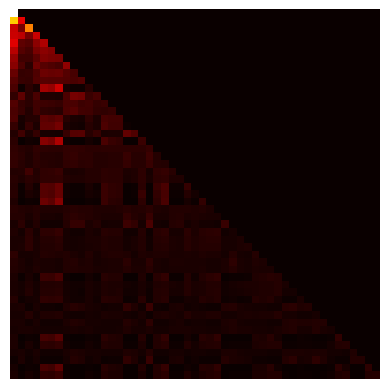

In [67]:
arr = arr.detach()
display_image(arr.cpu(), image_size=49, cmap='hot')

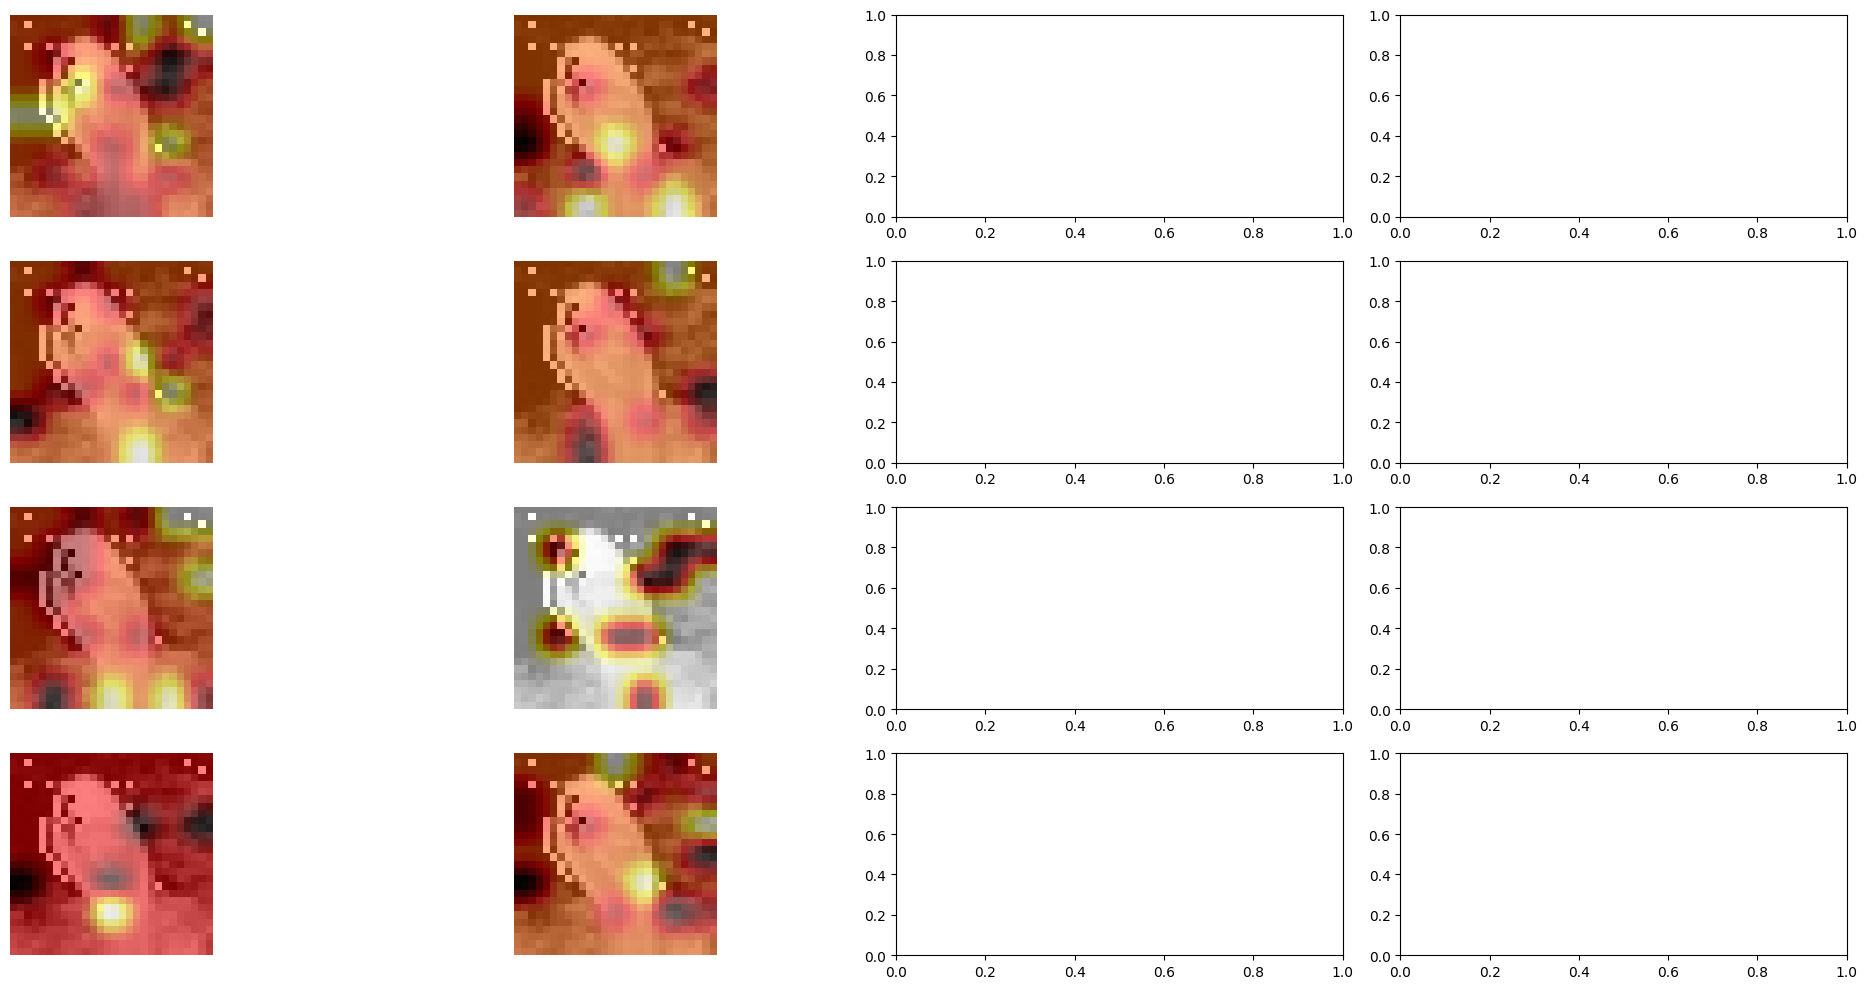

In [83]:
emb = Embedder().to(device)
image = t.Tensor(sorted_data[2][6][0]).view(28, 28)
e = emb(t.Tensor(image).to(device))
o = tf(e[None, :, :])
attn_patterns = tf.getAttnPatterns()
show_attn_patterns(image, attn_patterns, num_layers=4, num_heads=4)

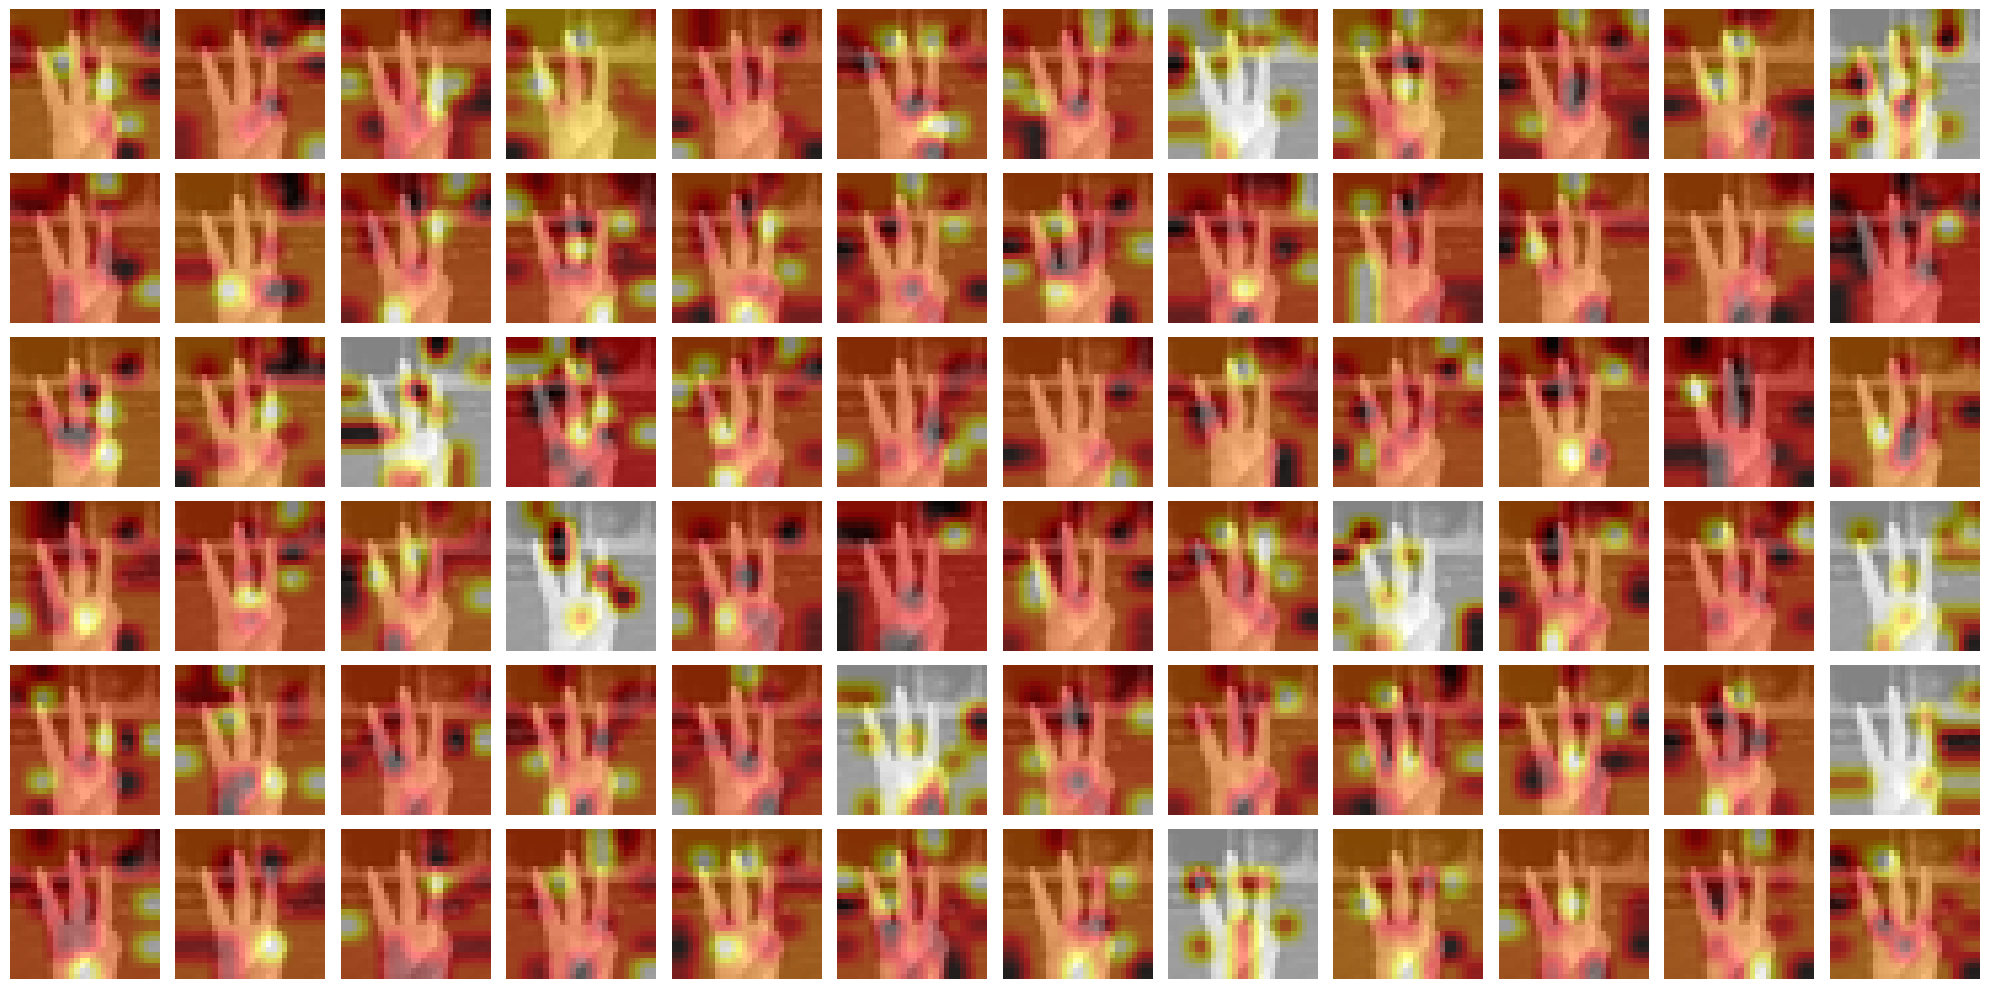

In [ ]:
‹emb = TrOCREmbedder(TFConfig(n_layers=6, init_range=0.08, d_mlp=420, n_classes=27)).to(device)
image = t.Tensor(sorted_data[22][6][0]).view(28, 28)
e = emb(t.Tensor(image).to(device))
o = model_final(e[None, :, :])
attn_patterns = model_final.getAttnPatterns()
show_attn_patterns(image, attn_patterns)

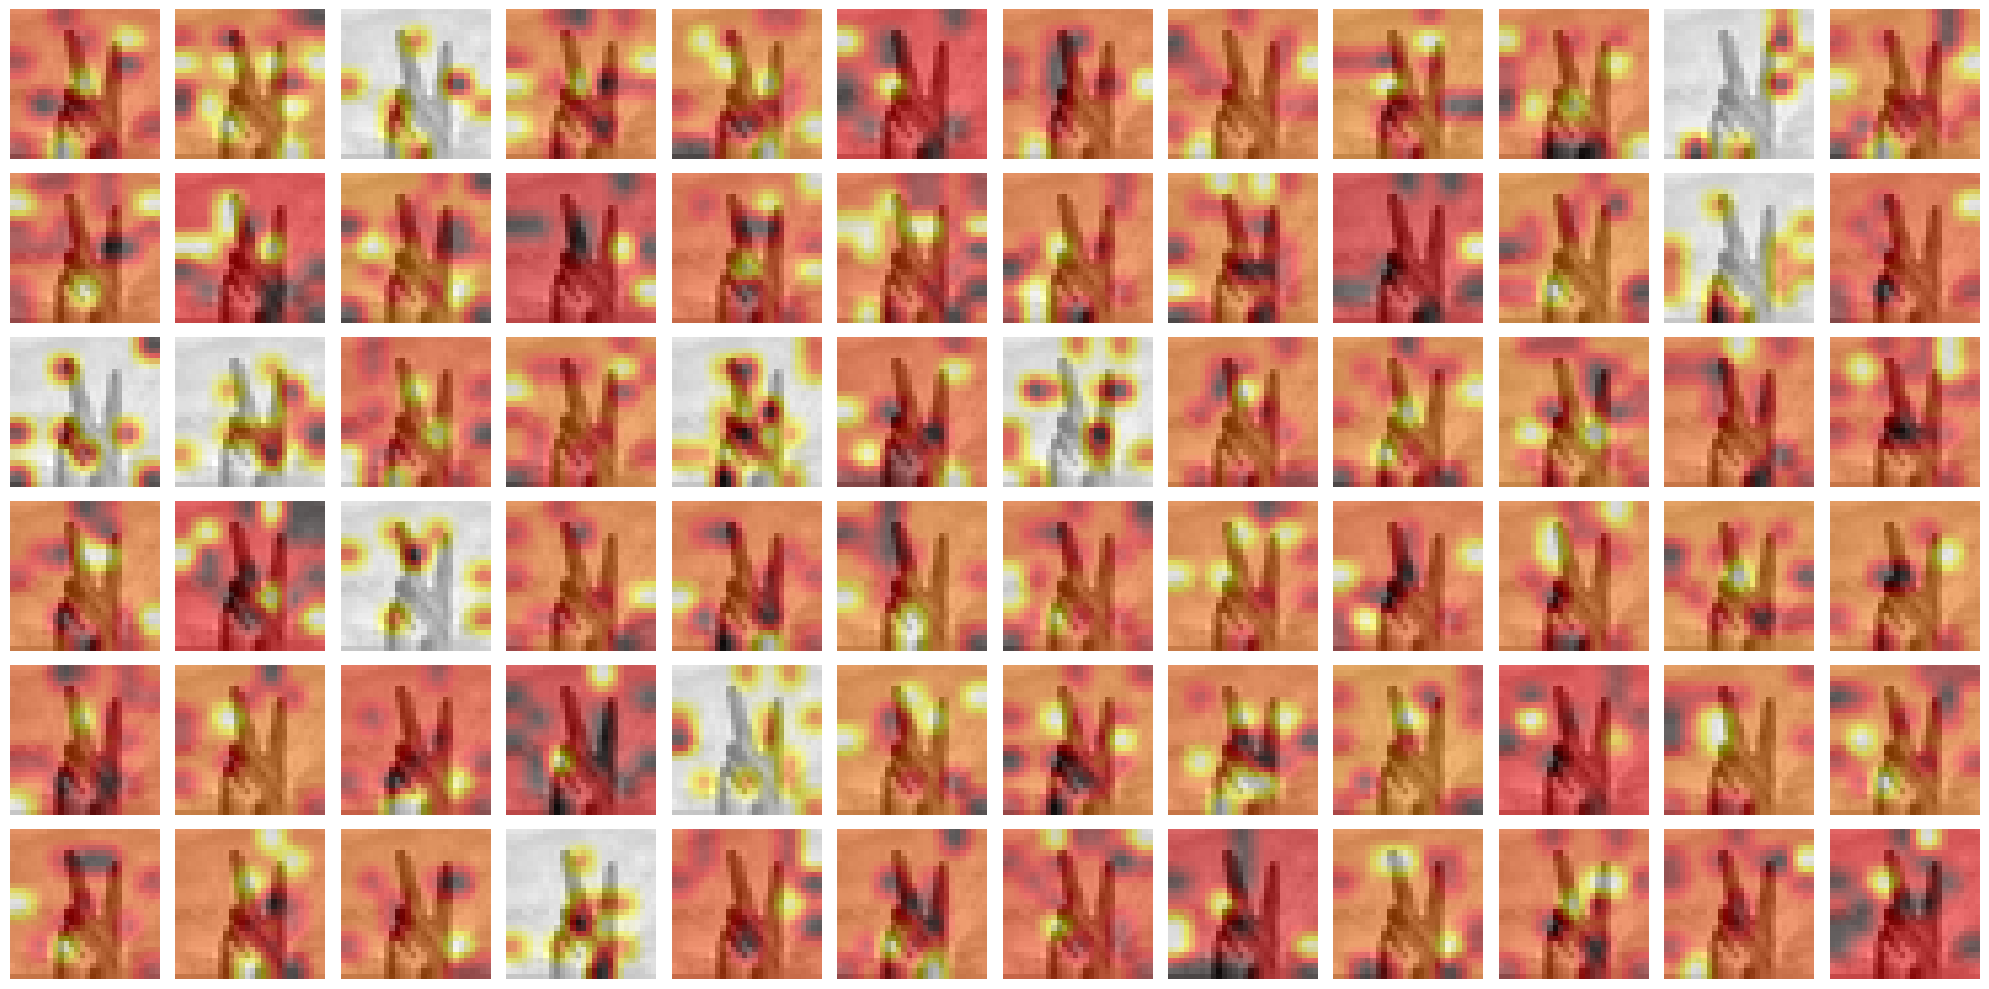

In [ ]:
emb = TrOCREmbedder(TFConfig(n_layers=6, init_range=0.08, d_mlp=420, n_classes=27)).to(device)
image = t.Tensor(sorted_data[21][4][0]).view(28, 28)
e = emb(t.Tensor(image).to(device))
o = model_final(e[None, :, :])
attn_patterns = model_final.getAttnPatterns()
show_attn_patterns(image, attn_patterns)

## Model Version Notes

> **Default with n_heads**
> trained for 2 epochs on everything: 75.97, 65.63, 72.15, 0.874 (All, A, B, C)
>




In [ ]:
tf_bugless = TrASLaHooked(TFConfig(n_heads=8, init_range=0.09, n_layers=4)).to(device)
embed = TrOCREmbedder(TFConfig()).to(device)

train_this(tf_bugless, embed, training_batches[:len(training_batches) - 500], len(training_batches) - 300, n_epochs=5, lr=1e-3)
train_this(tf_bugless, embed, clsA_training_batches, len(clsA_training_batches), n_epochs=1, lr=1e-4)
train_this(tf_bugless, embed, clsB_training_batches, len(clsB_training_batches), n_epochs=1, lr=1e-4)
train_this(tf_bugless, embed, training_batches, len(training_batches), n_epochs=1, lr=1e-5)

perf = test_this(tf_bugless, embed, testing_batches)
print(t.sum(t.diag(perf)) / t.sum(perf))
post_perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))
post_perf = test_this(tf_bugless, embed, clsB_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/5], Loss: 0.049269117414951324
Epoch [2/5], Loss: 0.01866777241230011
Epoch [3/5], Loss: 0.002541743917390704
Epoch [4/5], Loss: 0.008265437558293343
Epoch [5/5], Loss: 0.003924818709492683
Epoch [1/1], Loss: 1.0707498404372018e-05
Epoch [1/1], Loss: 3.605904203141108e-05
Epoch [1/1], Loss: 0.00012623246584553272
tensor(0.7571)
tensor(0.5999)
tensor(0.7288)


In [ ]:
t.save(tf_bugless.state_dict(), 'model_7892.pth')

In [ ]:
perf = test_this(tf_bugless, embed, testing_batches)
print(t.sum(t.diag(perf)) / t.sum(perf))

tensor(0.7749)


In [ ]:
perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(perf)) / t.sum(perf))

perf = test_this(tf_bugless, embed, clsB_testing_batches)
print(t.sum(t.diag(perf)) / t.sum(perf))

tensor(0.6379)
tensor(0.7196)


In [ ]:
train_this(tf_bugless, embed, clsA_training_batches, len(clsA_training_batches), n_epochs=3, lr=1e-5)
post_perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/3], Loss: 0.005081989802420139
Epoch [2/3], Loss: 0.00035433057928457856
Epoch [3/3], Loss: 0.00025480182375758886
tensor(0.6684)


In [ ]:
train_this(tf_bugless, embed, clsB_training_batches, len(clsB_training_batches), n_epochs=2, lr=1e-5)
post_perf = test_this(tf_bugless, embed, clsB_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/2], Loss: 0.0036125800106674433
Epoch [2/2], Loss: 2.0088502424187027e-05
tensor(0.7469)


In [ ]:
train_this(tf_bugless, embed, training_batches, len(training_batches), n_epochs=1, lr=1e-4)

Epoch [1/1], Loss: 0.0001914245804073289


In [ ]:
train_this(tf_bugless, embed, training_batches, len(training_batches), n_epochs=1, lr=1e-5)
post_perf = test_this(tf_bugless, embed, testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/1], Loss: 0.00014826901315245777
tensor(0.7729)


In [ ]:
post_perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))
post_perf = test_this(tf_bugless, embed, clsB_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

tensor(0.6390)
tensor(0.7450)


In [ ]:
print(t.sum(t.diag(perf)) / t.sum(perf))
print(t.argmax(perf, dim=1))

tensor(0.7573)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  0, 10, 11, 12, 12, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24,  0])


In [ ]:
train_this(tf_bugless, embed, clsA_training_batches, len(clsA_training_batches), n_epochs=1, lr=1e-5)
post_perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/1], Loss: 9.317836520494893e-05
tensor(0.6626)


In [ ]:
post_perf = test_this(tf_bugless, embed, testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

tensor(0.7739)


In [ ]:
train_this(tf_bugless, embed, training_batches, len(training_batches), n_epochs=1, lr=1e-6)
post_perf = test_this(tf_bugless, embed, testing_batches)
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

Epoch [1/1], Loss: 0.00029965571593493223
tensor(0.7743)


In [ ]:
# Differtn from above section -------
#Performance of tf_bugless_757 before finetuning: 62.98
pre_perf = test_this(tf_bugless, embed, clsA_testing_batches)
print(t.sum(t.diag(pre_perf)) / t.sum(pre_perf))

tensor(0.6298)


In [ ]:
train_this(tf_bugless, embed, clsA_training_batches, len(clsA_training_batches), n_epochs=1, lr=1e-5)
post_perf = test_this(tf_bugless, embed, clsA_testing_batches)

Epoch [1/1], Loss: 0.00023979146499186754


In [ ]:
# Performance of tf_bugless_757 after finetuning once: 65.52 (A)
# Performance on all after:
print(t.sum(t.diag(post_perf)) / t.sum(post_perf))

tensor(0.6552)


In [ ]:
t.save(tf_bugless.state_dict(), 'model_7743.pth')

In [ ]:
import string

In [ ]:
def calculate_f1_scores(conf_matrix):
    # Calculate precision and recall for each class
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Handle division by zero in precision and recall calculation
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)

    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero in F1 score calculation

    return f1_scores

def plot_f1_scores(f1_scores, num_classes):
    # Plot the F1 scores
    plt.figure(figsize=(10, 6))
    plt.bar(list(string.ascii_lowercase), f1_scores, color='blue')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores by Class')
    plt.xticks(range(num_classes))
    plt.show()

def plot_dataset_frequencies(freqs, num_classes):
    # Plot the F1 scores
    plt.figure(figsize=(10, 6))
    plt.bar(list(string.ascii_lowercase), f1_scores, color='blue')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores by Class')
    plt.xticks(range(num_classes))
    plt.show()


def plot_f1_and_freq(f1_scores, freqs,num_classes):
    # Plot the F1 scores
    plt.figure(figsize=(10, 6))
    plt.bar(list(string.ascii_lowercase), f1_scores, color='blue')
    plt.bar(list(string.ascii_lowercase), freqs, color='red')
    plt.xlabel('Class')
    plt.ylabel('F1 Score (Blue), Dataset Frequency (Red)')
    plt.title('F1 Scores by Class')
    plt.xticks(range(num_classes))
    plt.show()

In [ ]:
perf = perf.cpu()

In [ ]:
f1_scores = calculate_f1_scores(perf.numpy())

<ipython-input-44-8bc068c7048b>:3: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
<ipython-input-44-8bc068c7048b>:4: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
<ipython-input-44-8bc068c7048b>:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [ ]:
freqs = np.sum(perf.numpy(), axis=0)

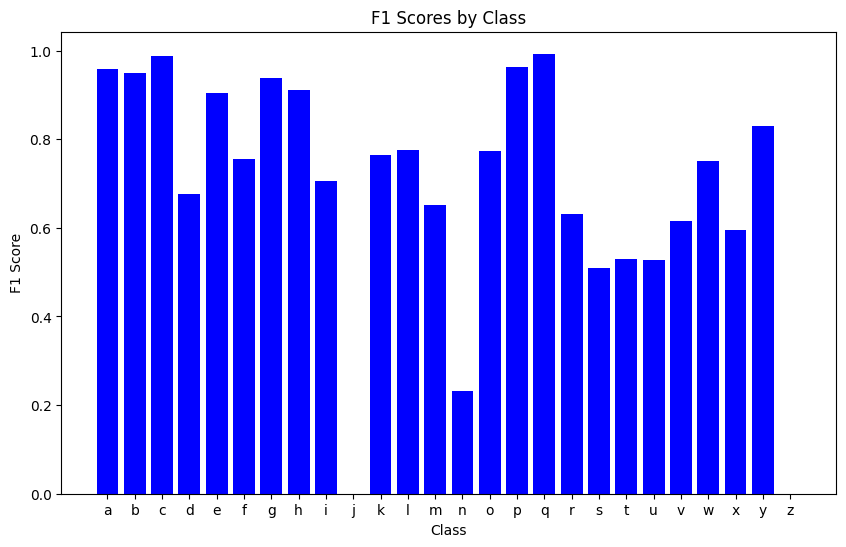

In [ ]:
plot_dataset_frequencies(freqs, 26)

In [ ]:
for i in perf:
    for j in i:
        print(f"{int(j)}", end='\t')
    print('')

290	0	0	0	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
0	289	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
0	0	291	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
0	14	0	190	0	0	0	0	0	0	1	0	35	0	0	18	0	13	0	0	2	16	0	0	0	0	
0	0	0	0	291	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
0	0	0	4	0	244	0	0	2	0	0	1	1	0	4	0	0	0	1	1	0	8	0	6	19	0	
0	0	0	0	0	0	263	8	0	0	0	0	0	0	16	0	1	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	9	280	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	
7	0	0	3	6	9	0	0	183	0	4	9	6	16	0	0	0	19	15	1	0	3	2	1	6	0	
0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	1	0	0	0	0	233	0	0	0	0	0	0	11	0	0	10	25	5	0	4	0	
0	0	1	19	0	1	0	0	0	0	0	201	3	17	0	0	0	0	0	13	0	0	0	4	31	0	
0	0	0	0	2	0	1	0	0	0	0	0	251	24	1	0	0	0	10	1	0	0	0	0	0	0	
1	0	0	2	21	5	0	0	2	0	4	0	101	48	5	0	0	0	39	33	12	3	0	2	11	0	
15	0	5	0	0	19	0	14	0	0	0	0	18	4	200	0	0	1	0	1	0	0	0	12	0	0	
0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	286	0	0	0	0	0	0	0	0	0	0	
0	0	0	0	0	0	0	0	0	0	0	0	1	0	2	0	286	0	0	0	0	0	0	0	0	0	
0	0	0	5	0	3	0	0	1	0	30	2	0	1	0	0	0	22

In [ ]:
train_this(tf_bugless, embed, 2000)

Epoch [1/9], Loss: 0.11843530088663101
Performance: 0.15153203342618385
Epoch [2/9], Loss: 0.11244555562734604
Performance: 0.18314763231197773
Epoch [3/9], Loss: 0.11828180402517319
Performance: 0.17311977715877438
Epoch [4/9], Loss: 0.14804445207118988
Performance: 0.1798050139275766
Epoch [5/9], Loss: 0.07734300196170807
Performance: 0.2096100278551532
Epoch [6/9], Loss: 0.11564964801073074
Performance: 0.2034818941504178
Epoch [7/9], Loss: 0.11085031181573868
Performance: 0.21587743732590528
Epoch [8/9], Loss: 0.10897179692983627
Performance: 0.21949860724233983
Epoch [9/9], Loss: 0.07056591659784317
Performance: 0.1967966573816156


In [ ]:
t.save(tf_bugless.state_dict(), 'model_41.pth')

In [ ]:
for i in perf:
    for j in i:
        print(f"{int(j)}", end='\t')
    print('')


In [ ]:
print(t.sum(t.diag(perf)) / t.sum(perf))
print(t.argmax(perf, dim=1))

tensor(0.4101)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  0, 10, 11, 13, 13,  4, 15, 16,  3,
        13, 13, 20, 21, 22, 23, 24,  0])


In [ ]:
tf_encoder = TrASLa(TFConfig()).to(device)
embed = TrOCREmbedder(TFConfig())

train_this(tf_encoder, embed, training_data[:500])

Epoch [1/10], Loss: 0.11980418860912323
Epoch [2/10], Loss: 0.03457208722829819
Epoch [3/10], Loss: 0.011634210124611855
Epoch [4/10], Loss: 0.005964111071079969
Epoch [5/10], Loss: 0.0033990638330578804
Epoch [6/10], Loss: 0.002080308273434639


In [ ]:
tf_decoder = TrASLa(TFConfig()).to(device)
embed = TrOCREmbedder(TFConfig()).to(device)

train_this(tf_decoder, embed, pct=len(training_batches), lr=1e-3)

In [ ]:
train_this(tf_decoder, embed, pct=len(training_batches), lr=1e-3, n_epochs=2)

Epoch [1/2], Loss: 0.0037393115926533937
Epoch [2/2], Loss: 0.03804401680827141


In [ ]:
test_this(tf_decoder, embed)

Performance: 0.46935933147632314


In [ ]:
len(training_batches)

2746

In [ ]:
tf_large = TrASLa(TFConfig()).to(device)
embed = TrOCREmbedder(TFConfig()).to(device)

train_this(tf_large, embed, pct=len(training_batches), lr=1e-3)
test_this(tf_large, embed)

Epoch [1/6], Loss: 0.1802380383014679
Epoch [2/6], Loss: 0.19198478758335114
Epoch [3/6], Loss: 0.11640410870313644
Epoch [4/6], Loss: 0.09149975329637527
Epoch [5/6], Loss: 0.05325000360608101
Epoch [6/6], Loss: 0.02621636353433132
Performance: 0.3998607242339833


In [ ]:
tf = TrASLa(TFConfig())
tf.load_state_dict(t.load('tr4L.pt'))

tf = tf.to(device)

In [ ]:
t.save(tf.state_dict(), 'tr4L.pt')

In [ ]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer1L = t.optim.Adam(tr1L.parameters(), lr=0.001)
optimizer2L = t.optim.Adam(tr1L.parameters(), lr=0.001)
optimizer6L = t.optim.Adam(tr1L.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 9
batch_size = 10


In [ ]:
tr4L = TrOCR(TFConfig(n_layers=4)).to(device)
optimizer4L = t.optim.Adam(tr4L.parameters(), lr=0.001)

In [ ]:

optimizer4L = t.optim.Adam(tr4L.parameters(), lr=0.001)
tr4L.train()
# Training loop
for epoch in range(10):
    random.shuffle(threshold_data)
    for batch_values, batch_labels in threshold_batches:
        # Forward pass
        outputs = tr4L(batch_values)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer4L.zero_grad()
        loss.backward()
        optimizer4L.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

In [ ]:
num_epochs = 10
optimizer4L = t.optim.Adam(tr4L.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
tr4L.train()
# Training loop
for epoch in range(num_epochs):
    random.shuffle(training_batches)
    epoch_loss = 0
    iteration = 0
    for batch_values, batch_labels in training_batches:
        #inputs = tuple(input.to(device) for input in inputs)

        # Turn targets into an object matching the output of the model

        # Forward pass
        outputs = tr4L(batch_values)
        loss = criterion(outputs, batch_labels)
        epoch_loss += loss.item()
        iteration += 1
        # Backward pass and optimization
        optimizer4L.zero_grad()
        loss.backward()
        optimizer4L.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], {epoch_loss/iteration}")

Epoch [1/10], 0.1005205292490739
Epoch [2/10], 0.09174550186234913
Epoch [3/10], 0.08362298883980673
Epoch [4/10], 0.0748375536448635
Epoch [5/10], 0.06825697406138126
Epoch [6/10], 0.06202818583513936
Epoch [7/10], 0.0574632444897516
Epoch [8/10], 0.05561156613272001
Epoch [9/10], 0.05187876682690543
Epoch [10/10], 0.04978368245338657


# Evaluation

In [ ]:
model = tr4L
model.eval()
with t.no_grad():
    val_loss = 0
    correct_predictions = 0
    num_predictions = 0
    for val_inputs, val_targets in testing_batches:
        val_targets = val_targets.to(device)

        # Forward pass
        val_outputs = model(val_inputs)

        val_loss += criterion(val_outputs, val_targets).item()

        # Get the predicted classes and actual classes
        # Assuming val_outputs are logits and val_targets are class indices
        predicted_classes = t.argmax(t.squeeze(val_outputs), dim=1)
        actual_classes = t.argmax(t.squeeze(val_targets), dim=1)
        # Compare and count correct predictions

        correct_predictions += (predicted_classes == actual_classes).sum().item()
        num_predictions += len(predicted_classes)

    # Calculate accuracy
    accuracy = correct_predictions / num_predictions
    print(f"Accuracy: {correct_predictions}/{num_predictions}   [{accuracy}%]")

Accuracy: 1340/7172   [0.1868377021751255%]


# Tinkering
- Performance scaling with the number of attention heads
- Performance scaling with the size of attention dim
-

In [ ]:
import cv2
import numpy as np

def capture_and_process_image():
    # Open the camera
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Cannot open camera")
        return None

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        # Display the resulting frame
        cv2.imshow('frame', frame)

        # Wait for spacebar to be pressed
        if cv2.waitKey(1) == ord(' '):
            # Convert to grayscale
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Resize to 28x28
            resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
            # Flatten the image to a 784-length vector
            flattened = resized.flatten()
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

    return flattened

# Example usage
image_vector = capture_and_process_image()
if image_vector is not None:
    print("Captured image vector:", image_vector)

Cannot open camera
